# TASK 1 - by Imane Sayd

In [ ]:
# Importing the necessary libraries
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor
import os, re, requests
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# TensorFlow tools
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences  
from tensorflow.keras.utils import to_categorical

# NLTK Resources
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Loading and filtering the dataset
#-------------------------------------------------------------------------------------------------------------------------------------#
df = pd.read_csv("nasa-apod-dataset.csv", sep=';')
df = df[df['media_type'] == 'image'].dropna(subset=['media_url'])


# Cleaning the text (stemming, stop words removal...)
#--------------------------------------------------------------------------------------------------------------------------------------#
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # removing punctuation, lowercase --> only letters and spaces
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)
df['clean_explanation'] = df['explanation'].apply(clean_text)


# Tokenization of the text (by converting the cleaned text into number sequences that an LSTM model can understand)
#---------------------------------------------------------------------------------------------------------------------------------------#
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>') # creating a dictionary of words and assigning each a number
tokenizer.fit_on_texts(df['clean_explanation']) # scanning through the cleaned text
sequences = tokenizer.texts_to_sequences(df['clean_explanation']) # converting each explanation into a list of word IDs
padded_texts = pad_sequences(sequences, maxlen=200) # ensuring the sequences have the same length since LSTM requires inputs of same shape

# Generating the labels
#-------------------------------------------------------------------------------------------------------------------------------------#
label_list = ['galaxy', 'nebula', 'star'] # num_classes is 4 (including 'other')

def extract_label(clean_explanation):
    for y in label_list:
        if pd.notna(clean_explanation) and y in clean_explanation.lower():
            return y
    return 'other'

df['label'] = df['clean_explanation'].apply(extract_label)

# Downloading and Resizing images
#----------------------------------------------------------------------------------------------------------------------------------------#
def download_and_resize(URL, size=(224, 224)):
    try:
        response = requests.get(URL, timeout=10)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        image = image.resize(size)
        return np.array(image) / 255.0  # normalization of the pixels
    except:
        return None

'''print("Downloading and Processing images... (it takes a while)")   
df['image_data'] = df['media_url'].apply(download_and_resize)
df.dropna(subset=['image_data'], inplace=True)'''

# List of URLs
URLs = df['media_url'].tolist()

# Multithreaded download
print("Downloading images in parallel...(it takes a while)")
with ThreadPoolExecutor(max_workers=16) as executor:  # can be adjusted to 8 or 32 (it depends on the system)
    image_data = list(executor.map(download_and_resize, URLs))

# Adding it back to the dataframe and modifying it
#---------------------------------------------------------------------------------------------------------------------------------------#
df['image_data'] = image_data
# Dropping messing images
df.dropna(subset=['image_data'], inplace=True)

print(f"Done! Kept {len(df)} images after download.")

# Recalculating clean_explanation, padded_texts and labels after dropping NaNs
df = df.reset_index(drop=True)  # resetting index for clean alignment

# Re-tokenizing and padding the filtered text
sequences = tokenizer.texts_to_sequences(df['clean_explanation'])
padded_texts = pad_sequences(sequences, maxlen=200)

# One-hot-encoding the labels after filtering
labels = pd.get_dummies(df['label']).values
#labels = to_categorical(df['label'].values)

# Assigning the variables
#----------------------------------------------------------------------------------------------------------------------------------------#
X_image = list(df['image_data'])
X_text = padded_texts
y = labels

# Splitting the dataset into 70/10/20
#----------------------------------------------------------------------------------------------------------------------------------------#
# 80% train + val vs 20% test
X_image_remaining, X_image_test, X_text_remaining, X_text_test, y_remaining, y_test = train_test_split(
    X_image, X_text, y, test_size=0.2, random_state=42)

# 10% of 80% of training -> validation 10% vs training 70%
X_image_train, X_image_val, X_text_train, X_text_val, y_train, y_val = train_test_split(
    X_image_remaining, X_text_remaining, y_remaining, test_size=1/8, random_state=42)

# Converting to arrays
X_image_train = np.array(X_image_train)
X_image_val = np.array(X_image_val)
X_image_test = np.array(X_image_test)

X_text_train = np.array(X_text_train)
X_text_val = np.array(X_text_val)
X_text_test = np.array(X_text_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print("Preprocessing complete.")
print(f"Training set: {len(X_image_train)}")
print(f"Validation set: {len(X_image_val)}")
print(f"Test set: {len(X_image_test)}")


e:\Documents2\AIEN422\NLP_project\tf-env\lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (136037232 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
e:\Documents2\AIEN422\NLP_project\tf-env\lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (89574664 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
e:\Documents2\AIEN422\NLP_project\tf-env\lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (105545760 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
e:\Documents2\AIEN422\NLP_project\tf-env\lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (114000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
e:\Documents2\AIEN422\NLP_project\tf-env\lib\site-packages\PIL\Image.py:3442: DecompressionBombWarnin

Done! Kept 9941 images after download.
Preprocessing complete.
Training set: 6958
Validation set: 994
Test set: 1989


In [3]:
# Saving everything
#----------------------------------------------------------------------------------------------------------------------------------------#
np.save("X_image_train.npy", X_image_train)
np.save("X_image_val.npy", X_image_val)
np.save("X_image_test.npy", X_image_test)

np.save("X_text_train.npy", X_text_train)
np.save("X_text_val.npy", X_text_val)
np.save("X_text_test.npy", X_text_test)

np.save("y_train.npy", y_train)
np.save("y_val.npy", y_val)
np.save("y_test.npy", y_test)

In [24]:
len(df)
df[['date', 'title', 'media_url', 'explanation', 'clean_explanation', 'image_data', 'label']].reset_index(drop=True)


date                                    title  \
0     1995-06-16                       Neutron Star Earth   
1     1995-06-20                    Pleiades Star Cluster   
2     1995-06-21                Supernova 1987a Aftermath   
3     1995-06-22                     Earth from Apollo 17   
4     1995-06-23                        Gamma Ray Sky Map   
...          ...                                      ...   
9936  2023-12-26            IC 443 : The Jellyfish Nebula   
9937  2023-12-27  Rainbow Aurora over Icelandic Waterfall   
9938  2023-12-28                  Jupiter and the Geminid   
9939  2023-12-29                     Shakespeare in Space   
9940  2023-12-30                       The Last Full Moon   

                                              media_url  \
0           https://apod.nasa.gov/apod/image/e_lens.gif   
1        https://apod.nasa.gov/apod/image/pleiades2.gif   
2      https://apod.nasa.gov/apod/image/sn1987a_hst.gif   
3        https://apod.nasa.gov/apod/image/earth_a17.gif   
4        https://apod.nasa.gov/apod/image/egret_gro.gif   
...                                                 ...   
9936  https://apod.nasa.gov/apod/image/2312/Jellyfis...   
9937  https://apod.nasa.gov/apod/image/2312/ArchFall...   
9938  https://apod.nasa.gov/apod/image/2312/G0030446...   
9939  https://apod.nasa.gov/apod/image/2312/STScI-Ur...   
9940  https://apod.nasa.gov/apod/image/2312/2023_12_...   

                                            explanation  \
0     Today's Picture : Explanation : If the Earth c...   
1     Today's Picture : June 20, 1995 The Pleiades S...   
2     Today's Picture : June 21, 1995 The Aftermath ...   
3     In 1972 Astronauts on the United States's last...   
4     What if you could "see" gamma rays ? This comp...   
...                                                 ...   
9936  Why is this jellyfish swimming in a sea of sta...   
9937  Yes, but can your aurora do this ? First, yes,...   
9938  For a brief moment, this brilliant fireball me...   
9939  In 1986, Voyager 2 became the only spacecraft ...   
9940  Known to some in the northern hemisphere as De...   

                                      clean_explanation  \
0     today pictur explan earth could somehow transf...   
1     today pictur june pleiad star cluster pictur m...   
2     today pictur june aftermath great supernova pi...   
3     astronaut unit statess last lunar mission apol...   
4     could see gamma ray comput process imag repres...   
...                                                 ...   
9936  jellyfish swim sea star drift near bright star...   
9937  ye aurora first ye aurora look like rainbow ev...   
9938  brief moment brilliant firebal meteor outshon ...   
9939  voyag becam spacecraft explor ice giant planet...   
9940  known northern hemispher decemb cold moon long...   

                                             image_data   label  
0     [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...    star  
1     [[[0.06666666666666667, 0.043137254901960784, ...    star  
2     [[[0.8901960784313725, 0.8901960784313725, 0.8...    star  
3     [[[0.03529411764705882, 0.0, 0.0], [0.05098039...   other  
4     [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   other  
...                                                 ...     ...  
9936  [[[0.22745098039215686, 0.2823529411764706, 0....  nebula  
9937  [[[0.08235294117647059, 0.08627450980392157, 0...    star  
9938  [[[0.06666666666666667, 0.09019607843137255, 0...    star  
9939  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   other  
9940  [[[0.12941176470588237, 0.14901960784313725, 0...   other  

[9941 rows x 7 columns]

In [25]:
df.to_csv("apod_cleaned.csv", sep=';', index=False)
print("The new dataset is saved successfully!")
#df.topickle("apod_cleaned.pkl")

The new dataset is saved successfully!


In [15]:
len(X_image_train), len(X_image_val), len(X_image_test), len(X_text_train), len(X_text_val), len(X_text_test), len(y_train), len(y_val), len(y_test)

(6958, 994, 1989, 6958, 994, 1989, 6958, 994, 1989)

Displaying the first 5 images:



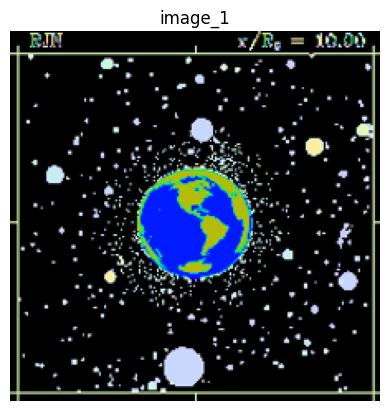

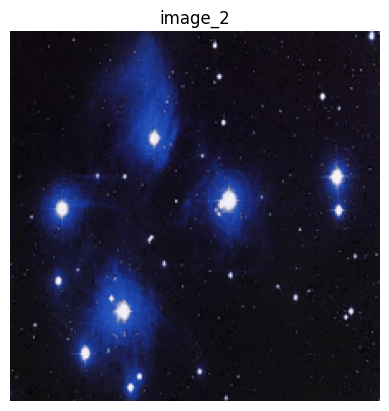

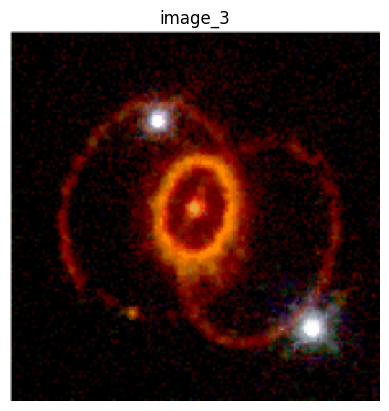

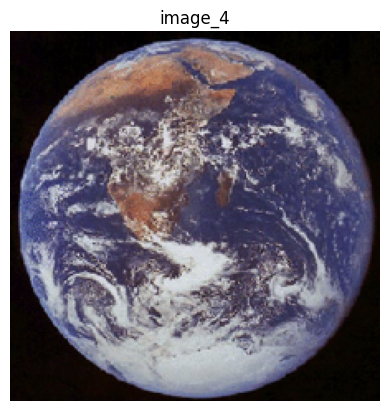

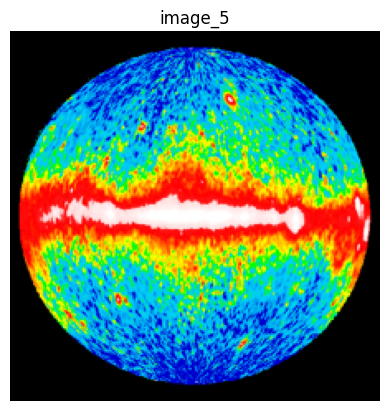

Displaying the last 5 images:



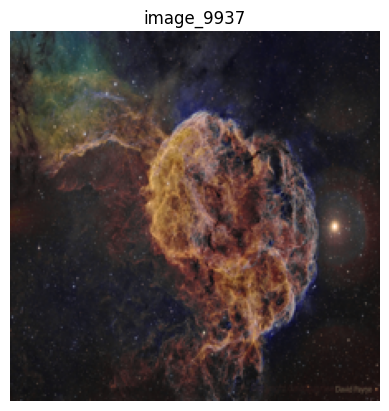

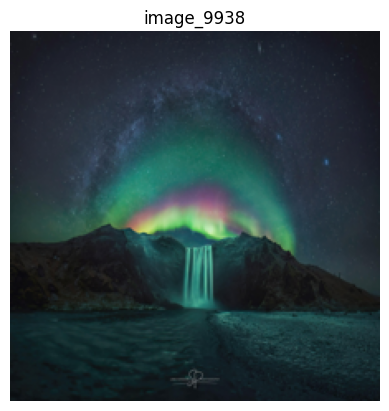

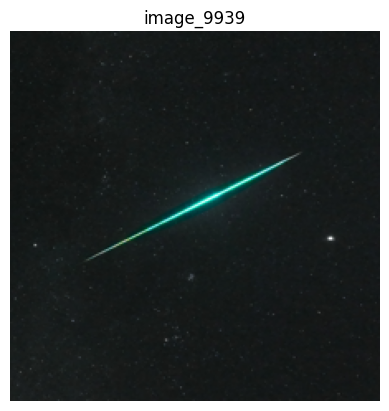

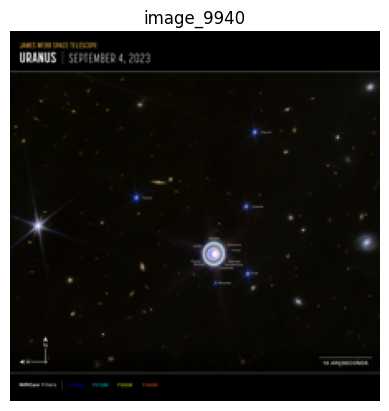

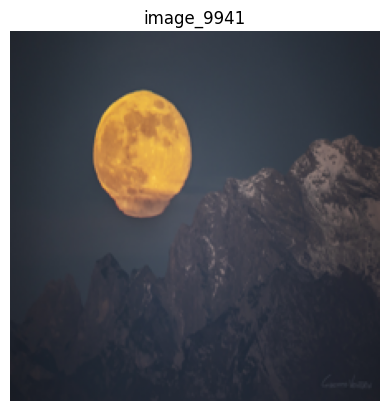

In [19]:
# Showing the first 5 images of the dataset
print("Displaying the first 5 images:\n")
for i in range(5):
    plt.imshow(X_image[i])
    plt.axis('off')
    plt.title(f"image_{i+1}")
    plt.show()

# Displaying the last 5 images of the dataset
print("Displaying the last 5 images:\n")
for i in range(9936, 9941):
    plt.imshow(X_image[i])
    plt.axis('off')
    plt.title(f"image_{i+1}")
    plt.show()

Displaying the first 5 training images:



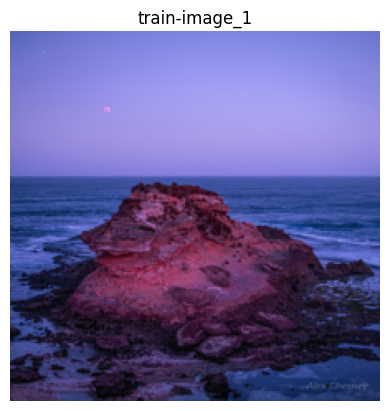

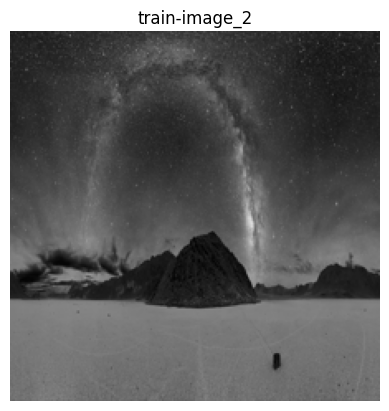

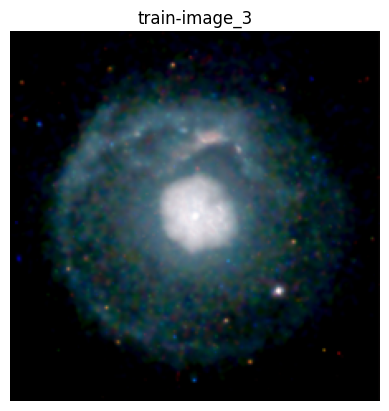

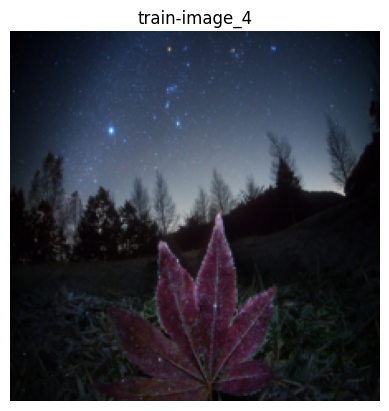

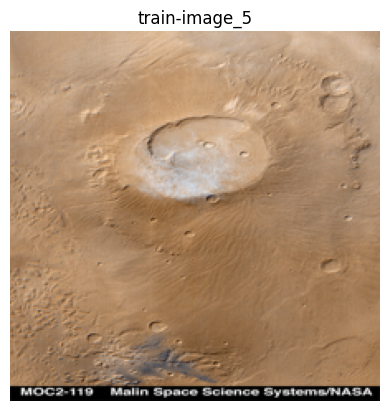

Saving the training images to 'train_images/' folder...
Done! training images saved in 'train_images/'


In [26]:
# Creating a folder to save the training image data
os.makedirs("train_images", exist_ok=True)

# Displaying the first 5 training images
print("Displaying the first 5 training images:\n")
for i in range(5):
    plt.imshow(X_image_train[i])
    plt.axis('off')
    plt.title(f"train-image_{i+1}")
    plt.show()

# Saving the images as .jpg files
print("Saving the training images to 'train_images/' folder...")
for i in range(len(X_image_train)):
    image = (X_image_train[i] * 255).astype(np.uint8)  # converting back to 0–255 (pixel)
    img = Image.fromarray(image)
    img.save(f"train_images/train-image_{i+1}.jpg")

print("Done! training images saved in 'train_images/'")

Displaying the first 5 validation images:



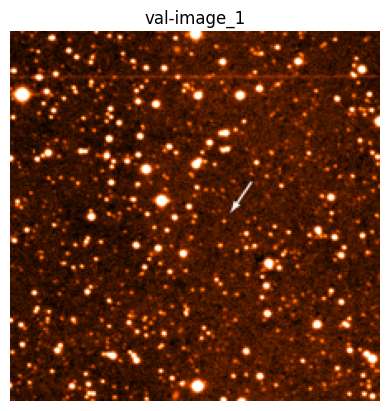

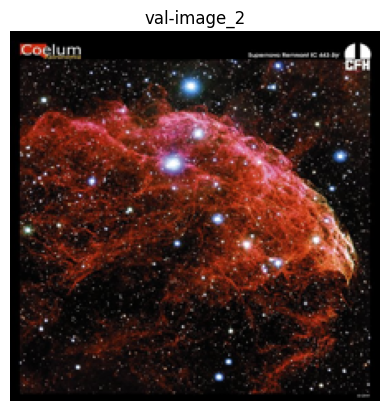

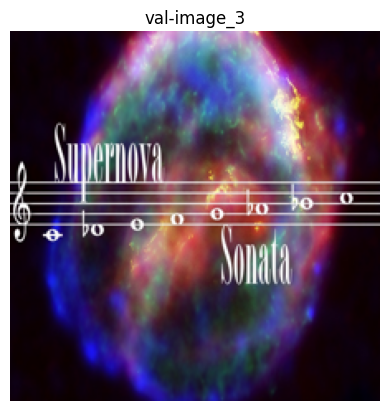

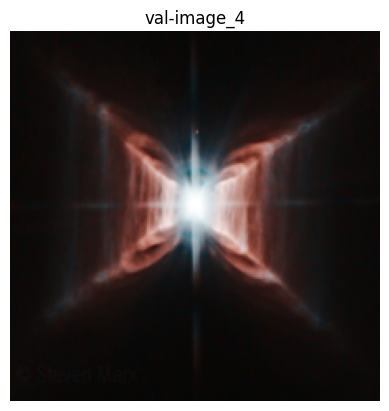

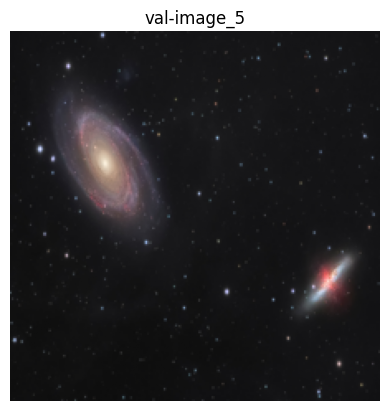

Saving the validation images to 'val_images/' folder...
Done! Validation images are saved in 'val_images/'


In [27]:
# Creating a folder to save the validation image data
os.makedirs("val_images", exist_ok=True)

# Displaying the first 5 validation images
print("Displaying the first 5 validation images:\n")
for i in range(5):
    plt.imshow(X_image_val[i])
    plt.axis('off')
    plt.title(f"val-image_{i+1}")
    plt.show()

# Saving the images as .jpg files
print("Saving the validation images to 'val_images/' folder...")
for i in range(len(X_image_val)):
    image = (X_image_val[i] * 255).astype(np.uint8)  # converting back to 0–255 (pixel)
    img = Image.fromarray(image)
    img.save(f"val_images/val-image_{i+1}.jpg")

print("Done! Validation images are saved in 'val_images/'")

Displaying the first 5 test images:



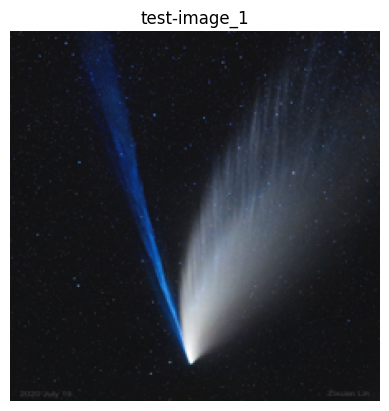

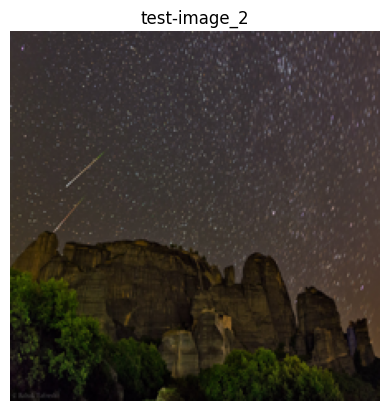

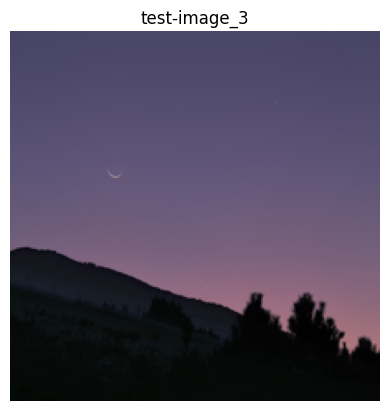

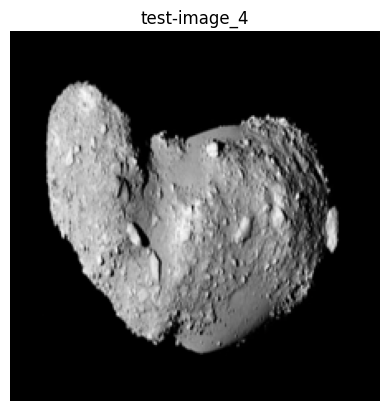

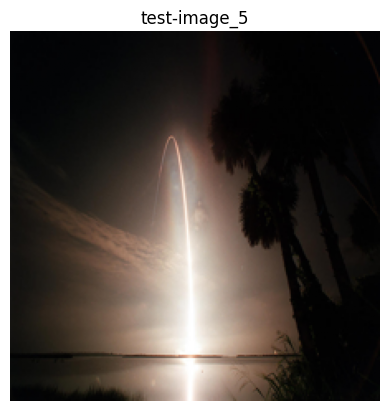

Saving the test images to 'test_images/' folder...
Done! test images are saved in 'test_images/'


In [28]:
# Creating a folder to save the images
os.makedirs("test_images", exist_ok=True)

# Displaying the first 5 test images
print("Displaying the first 5 test images:\n")
for i in range(5):
    plt.imshow(X_image_test[i])
    plt.axis('off')
    plt.title(f"test-image_{i+1}")
    plt.show()

# Saving the images as .jpg files
print("Saving the test images to 'test_images/' folder...")
for i in range(len(X_image_test)):
    image = (X_image_test[i] * 255).astype(np.uint8)  # converting back to 0–255 (pixel)
    img = Image.fromarray(image)
    img.save(f"test_images/test-image_{i+1}.jpg")

print("Done! test images are saved in 'test_images/'")